**Imports**

In [1]:

import os
import json
import pathlib
import pickle

import numpy as np
import pandas as pd
import hyperopt

import sklearn as sk
import sklearn.pipeline

import pyplotterlib.standard.plotters as ppl


import project_path
import model_wrappers as modelWrapHelp
import preproc_pipes as preProcPipeHelp
import train_pipes as trainPipeHelp

**Configuration Variables**

In [2]:
#Both need to be True on first run through
RERUN_SINGLE_HP = False
RERUN_HYPEROPT = False

#
TRAIN_PATH = os.path.abspath( os.path.join("..","..","raw_data","train.csv")  )

#
SAVE_FOLDER = os.path.join( os.getcwd(), "xgboost_tune" )

#
RANDOM_SEEDS = [78509, 64116, 69378, 66115, 83655]

#Also same features used for PCA
FEATS_TO_CLUSTER = ['OverallQual','GrLivArea','TotalBsmtSF','Neighborhood_m10','BsmtFinSF1',
            'GarageFinish','KitchenQual','GarageArea','SaleCondition_m10','LotArea',
            'MoSold','LotShape', 'FireplaceQu','BsmtExposure', 'TotRmsAbvGrd',
            'YearRemodAdd', 'MSSubClass','WoodDeckSF','MasVnrArea']
N_KMEANS_CLUSTERS = 2

#
EXTRA_FEATS = ["BsmtFractUnfurnished", "GarageAreaTimesFinish", "NumbBsmtBath", "NumbBath",
               "OverallQualTimesCond", "PoolQualTimesCond", "PorchLikeArea", "Spaciousness",
               "TotalSFLiv", "TotalSFLivOverLotArea", "YearSold_Fract"]


#
TARG_ENC_FEATS = ["Neighborhood", "Exterior1st", "Condition1", "HouseStyle", "GarageType",
                  "Foundation", "LotConfig", "SaleType", "RoofMatl", "MSZoning", "SaleCondition",
                  "RoofStyle"]
TARG_ENC_MVAL = 10

#
TOP_CMI = ['TotalSFLiv', 'YearBuilt', 'OverallQualTimesCond', 'BsmtUnfSF', 'LotArea',
                  'GarageAreaTimesFinish', 'BsmtQual', 'Neighborhood', 'Neighborhood_m10',
                  'TotRmsAbvGrd', 'PorchLikeArea',
                  'SaleCondition', 'BsmtFinSF1', 'GrLivArea', 'KitchenQual', 'BsmtExposure',
                  'BsmtFinType1', 'FireplaceQu', 'LandContour', 'HeatingQC', 'MasVnrArea']

#
_currKwargs = {"constrainedLayout":True, "figHeightPerRow":2.5, "figWidthPerCol":4, "nColsGrid":4}
RECT_PLOTTER = ppl.RectMultiPlotter(**_currKwargs)


**Define the features to use**

In [3]:
FEATS = list(TOP_CMI) + ["clusterIdx", "cDist_0", "cDist_1", "clusterMinDist"] + ["pc_0"]

**Create our save folder**

In [4]:
pathlib.Path(SAVE_FOLDER).mkdir(exist_ok=True, parents=True)

**Import data**

In [5]:
RAW_TRAIN = pd.read_csv(TRAIN_PATH)

**Apply shared pre-processing options**

In [6]:
#Remove anything from the training set i know to be an outlier [from results in other notebooks]
_outlierIDs = [524, 945, 1299]

#Features we add before any factorisation/cleaning
_preFactorFeats = ["FenceQual", "NumbStoreys_fromHouseStyle"]

#
_ordEncoder = preProcPipeHelp.OrdinalEncoder( preProcPipeHelp.getStandardOrdinalEncodeKeys() )

#
_preProcComps = [ ("Add some pre-factorisation features", preProcPipeHelp.EngFeatureAdder(_preFactorFeats) ),
                  ("Remove outliers", preProcPipeHelp.RemoveOutliersById(_outlierIDs) ),
                 ("Replace text values with basic ordinal encoding", _ordEncoder),
                 ("Factorise any remaining categorical groups", preProcPipeHelp.FactorizeRemainingCateGroups() ), ]

preProcPipe = sk.pipeline.Pipeline(_preProcComps)


In [7]:
PROC_TRAIN = preProcPipe.fit_transform(RAW_TRAIN)

**Create a training pipe; applied to all at training time**

In [8]:
#
_targEncodeTrain = trainPipeHelp.MEncodeMultiple(TARG_ENC_FEATS, mVal=TARG_ENC_MVAL)
_pcaPipe = trainPipeHelp.AddPCA(FEATS_TO_CLUSTER, nComponents=1)
_clusterPipe = trainPipeHelp.AddKMeansClusters(FEATS_TO_CLUSTER, N_KMEANS_CLUSTERS, randomState=RANDOM_SEEDS[0],
                                               useMinDist=True)

_trainPipeComps = [ ("Impute NaN values for numerical fields", trainPipeHelp.TransformNumericalNaN()),
                    ("Add remaining engineered features", preProcPipeHelp.EngFeatureAdder(EXTRA_FEATS) ),
                    ("Add target encoded features", _targEncodeTrain ),
                    ("Add PCA component(s)", _pcaPipe),
                    ("Add kmeans cluster information", _clusterPipe)
                  ]
TRAIN_PIPE = sk.pipeline.Pipeline(_trainPipeComps)


**Do a small amount of single-variable exploration before doing a proper random search**

In [9]:
def getMeanAndStdDevFromCV(key, vals):
    useKwargs = [ {key:val} for val in vals]
    meanVals, stdDevs = list(), list()
    for opts in useKwargs:
        currVals = _calcScoresFromBoostKwargs(**opts)
        meanVals.append( np.mean(currVals) )
        stdDevs.append( np.std(currVals) )
    return meanVals, stdDevs


#
def _calcScoresFromBoostKwargs(**kwargs):
    inpFrame, inpFeats = PROC_TRAIN, FEATS
    randomSeeds = RANDOM_SEEDS
    return _scoreForRandomSeedShuffles(inpFrame, inpFeats, randomSeeds, logTarget=True, boostKwargs=kwargs)

#
def _scoreForRandomSeedShuffles(inpFrame, inpFeats, randomSeeds, logTarget=True, boostKwargs=None):
    outVals = list()
    useModel = modelWrapHelp.XGBoostWrapper(inpFeats, trainPipe=TRAIN_PIPE,
                                                 logTarget=logTarget,xgbKwargs=boostKwargs)
    for seed in randomSeeds:
        useX = inpFrame.copy()
        useX = useX.sample(frac=1.0, random_state=seed)
        currScore = np.mean( sk.model_selection.cross_val_score(useModel, useX) )
        outVals.append(currScore)
    return outVals




In [10]:
SINGLE_HP_MEANS_DICT = {}
SINGLE_HP_STD_DICT = {}

Vary estimators

In [11]:
%%prun
#   84431324 function calls (83299809 primitive calls) in 243.458 seconds



currKey = "n_estimators"
currVals = [40,60,100,160, 500, 1000]

if RERUN_SINGLE_HP:
    currMeans, currStds = getMeanAndStdDevFromCV(currKey, currVals)
    SINGLE_HP_MEANS_DICT[currKey] = [ [val,mean] for val,mean in zip(currVals,currMeans) ]
    SINGLE_HP_STD_DICT[currKey] = [ [val,stdDev] for val,stdDev in zip(currVals,currStds) ]

Vary max depth

In [12]:
%%prun
# 108684879 function calls (107176407 primitive calls) in 304.464 seconds

currKey = "max_depth"
currVals = [2,3,4,5,6,7,8,9]


if RERUN_SINGLE_HP:
    currMeans, currStds = getMeanAndStdDevFromCV(currKey, currVals)
    SINGLE_HP_MEANS_DICT[currKey] = [ [val,mean] for val,mean in zip(currVals,currMeans) ]
    SINGLE_HP_STD_DICT[currKey] = [ [val,stdDev] for val,stdDev in zip(currVals,currStds) ]


Vary learning rate

In [13]:
%%prun
# 122270601 function calls (120573570 primitive calls) in 347.643 seconds


currKey = "learning_rate"
currVals = [0.01, 0.02, 0.05, 0.1,0.2,0.3,0.4,0.5,0.6]


if RERUN_SINGLE_HP:
    currMeans, currStds = getMeanAndStdDevFromCV(currKey, currVals)
    SINGLE_HP_MEANS_DICT[currKey] = [ [val,mean] for val,mean in zip(currVals,currMeans) ]
    SINGLE_HP_STD_DICT[currKey] = [ [val,stdDev] for val,stdDev in zip(currVals,currStds) ]


Vary subsampling

In [14]:
%%prun
#
currKey = "subsample"
currVals = [0.2, 0.3, 0.5, 0.7, 0.8, 0.9, 1.0]


if RERUN_SINGLE_HP:
    currMeans, currStds = getMeanAndStdDevFromCV(currKey, currVals)
    SINGLE_HP_MEANS_DICT[currKey] = [ [val,mean] for val,mean in zip(currVals,currMeans) ]
    SINGLE_HP_STD_DICT[currKey] = [ [val,stdDev] for val,stdDev in zip(currVals,currStds) ]



**Save or load the single params dicts; so i dont have to rerun everything**

In [15]:
_singleParamsPath_mean = os.path.join(SAVE_FOLDER, "single_params_means")
_singleParamsPath_stdDev = os.path.join(SAVE_FOLDER, "single_params_std_dev")

if RERUN_SINGLE_HP:
    with open(_singleParamsPath_mean,"wt") as f:
        json.dump(SINGLE_HP_MEANS_DICT, f)
    with open(_singleParamsPath_stdDev,"wt") as f:
        json.dump(SINGLE_HP_STD_DICT, f)

else:
    with open(_singleParamsPath_mean,"rt") as f:
        SINGLE_HP_MEANS_DICT = json.load(f)
    with open(_singleParamsPath_stdDev,"rt") as f:
        SINGLE_HP_STD_DICT = json.load(f)
        

In [16]:
SINGLE_HP_MEANS_DICT

{'n_estimators': [[40, 0.12960006522843373],
  [60, 0.1292509481007768],
  [100, 0.1291346774338063],
  [160, 0.12909613455698993],
  [500, 0.12908647457645428],
  [1000, 0.12908647457645428]],
 'max_depth': [[2, 0.12562661174241965],
  [3, 0.12646150962869307],
  [4, 0.12783991815212634],
  [5, 0.1285457677766244],
  [6, 0.1291346774338063],
  [7, 0.12988538171950922],
  [8, 0.1306162497069297],
  [9, 0.1319002826473588]],
 'learning_rate': [[0.01, 4.234268382763611],
  [0.02, 1.5463231591296722],
  [0.05, 0.1459213683943196],
  [0.1, 0.12307842412921235],
  [0.2, 0.1261088861233925],
  [0.3, 0.1291346774338063],
  [0.4, 0.13571089250698126],
  [0.5, 0.14303990871356898],
  [0.6, 0.14443224956247813]],
 'subsample': [[0.2, 0.1686653033320153],
  [0.3, 0.1542346607926392],
  [0.5, 0.1405042045092934],
  [0.7, 0.13406846663608724],
  [0.8, 0.13316560731321228],
  [0.9, 0.13076249176074678],
  [1.0, 0.1291346774338063]]}

**Make plots looking at the effect of varying parameters one at a time**

In [17]:
#Create individual plotters for showing the mean and standard deviation
_currKwargs = {"fontSizeDefault":10, "gridLinesShowX":True,"lineMarkerStyles":["x"],
               "showMinorTickMarkersX":True,"xLabelStr":"Parameter Value"}
templPlotter = ppl.LinePlotter(**_currKwargs)

meanTemplPlotter = templPlotter.createFactory(axisColorY='r', axisColorY_exclSpines=True,
                                              lineColors=['r'], yLabelStr="Mean Loss")
stdTemplPlotter = templPlotter.createFactory(axisColorY='b', axisColorY_exclSpines=True,
                                             lineColors=['b'], yLabelStr = "Std-Dev Loss")

doubleAxTemplPlotter = ppl.DoubleAxisPlotter(independentYAxis=True)

In [18]:
usePlotters = list()
for key in SINGLE_HP_MEANS_DICT.keys():
    meanPlotter = meanTemplPlotter.createFactory(plotData=[SINGLE_HP_MEANS_DICT[key]], titleStr=key )
    stdPlotter = stdTemplPlotter.createFactory(plotData=[SINGLE_HP_STD_DICT[key]], titleStr=key)
    currPlotter = doubleAxTemplPlotter.createFactory(plotters=[meanPlotter, stdPlotter])
    usePlotters.append(currPlotter)

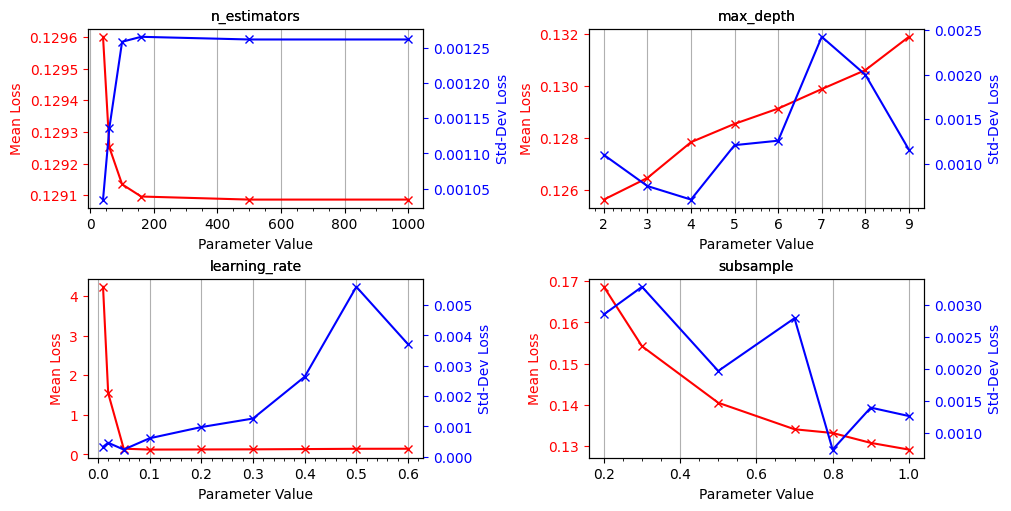

In [19]:
unused = RECT_PLOTTER.createPlot(plotters=usePlotters, nColsGrid=2, figWidthPerCol=5)

**Setup a space of hyperparameters**

In [20]:
_nEstChoices = [40, 60, 80, 100, 120, 140]
_learnRateChoices =  [0.05, 0.1, 0.15, 0.20]
searchSpace = {"maxDepth": hyperopt.hp.uniformint("max_depth", 2, 6),
               "nEstimators": hyperopt.hp.choice("n_estimators", _nEstChoices),
               "learnRate": hyperopt.hp.choice("learning_rate", _learnRateChoices) }

**setup the objective function**

In [21]:
def objectiveFunction(searchSpace):
    kwargs = {"max_depth": searchSpace["maxDepth"], "n_estimators":searchSpace["nEstimators"],
              "learning_rate": searchSpace["learnRate"]}
    return np.mean( _calcScoresFromBoostKwargs(**kwargs)  )


**Run**

In [22]:
%%prun
#         680320425 function calls (670862638 primitive calls) in 1922.447 seconds
trials = hyperopt.Trials()

if RERUN_HYPEROPT:
    best_hyperparams = hyperopt.fmin(fn = objectiveFunction,
                            space = searchSpace,
                            algo = hyperopt.tpe.suggest,
                            max_evals = 50,
                            trials = trials)

**Save or load the relevant Trials object**

In [23]:
trialsSavePath = os.path.join(SAVE_FOLDER, "trials.json")

if RERUN_HYPEROPT:
    with open(trialsSavePath, 'wb') as f:
        pickle.dump(trials, f)
else:
    with open(trialsSavePath, 'rb') as f:
        trials = pickle.load(f)
    


**Look at the top N hyperparameter values**

In [24]:
def getTopNResultsFromTrials(inpTrails, choiceParamMaps, useParams, nVals):
    sortedTrials = sorted(inpTrials, key = lambda x: x["result"]["loss"])
    outVals = list()
    for trial in sortedTrials[:nVals]:
        currDict = {}
        currDict["loss"] = trial["result"]["loss"]
        for param in useParams:
            choiceParam = False
            try:
                choiceParamMaps[param]
            except KeyError:
                pass
            else:
                choiceParam = True

            if choiceParam:
                choiceMap = choiceParamMaps[param]
                currDict[param] = choiceMap[ trial["misc"]["vals"][param][0] ]
            else:
                currDict[param] = trial["misc"]["vals"][param][0]
        outVals.append(currDict)
    return outVals

In [25]:
#
inpTrials = trials
choiceParamMaps = {"learning_rate":_learnRateChoices, "n_estimators":_nEstChoices}
useParams = ["learning_rate", "n_estimators", "max_depth"]
nVals = 20

#
getTopNResultsFromTrials(inpTrials, choiceParamMaps, useParams, nVals)

[{'loss': 0.12223111673863299,
  'learning_rate': 0.1,
  'n_estimators': 140,
  'max_depth': 4.0},
 {'loss': 0.12223111673863299,
  'learning_rate': 0.1,
  'n_estimators': 140,
  'max_depth': 4.0},
 {'loss': 0.12223111673863299,
  'learning_rate': 0.1,
  'n_estimators': 140,
  'max_depth': 4.0},
 {'loss': 0.12223111673863299,
  'learning_rate': 0.1,
  'n_estimators': 140,
  'max_depth': 4.0},
 {'loss': 0.12223111673863299,
  'learning_rate': 0.1,
  'n_estimators': 140,
  'max_depth': 4.0},
 {'loss': 0.12235656698553785,
  'learning_rate': 0.1,
  'n_estimators': 120,
  'max_depth': 5.0},
 {'loss': 0.12238091689692057,
  'learning_rate': 0.1,
  'n_estimators': 140,
  'max_depth': 5.0},
 {'loss': 0.12238091689692057,
  'learning_rate': 0.1,
  'n_estimators': 140,
  'max_depth': 5.0},
 {'loss': 0.12238091689692057,
  'learning_rate': 0.1,
  'n_estimators': 140,
  'max_depth': 5.0},
 {'loss': 0.12260451397312093,
  'learning_rate': 0.1,
  'n_estimators': 140,
  'max_depth': 3.0},
 {'loss': 